# Temporal Community Structure Experiments

Referenced Work: [Schapiro et al., 2013](https://www.nature.com/articles/nn.3331), [Stachenfeld et al., 2017](https://www.nature.com/articles/nn.4650).

In humans, certain brain regions such as the hippocampus display representations of stimuli which correspond not to the underlying properties of the stimuli, but to the temporal community structure of the underlying state space from which they were drawn. This notebook reproduces experiments showing two different approaches to generating similar representations using computational models.

In [1]:
# Uncomment below lines and run this cell to install neuronav and requirements for colab.

#!git clone https://github.com/awjuliani/neuro-nav
#!pip install ./neuro-nav[experiments_remote]

### Imports and helper functions

In [2]:
from neuronav.envs.graph_env import GraphEnv, GraphObsType
from neuronav.agents.td_agents import TDSR
from neuronav.envs.graph_structures import GraphStructure
from neuronav.utils import run_episode
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import torch
import torch.nn as nn

In [3]:
def build_color_list(items):
    color_list = []
    for item in items:
        if item < 5:
            color_list.append("red")
        elif item < 10:
            color_list.append("blue")
        else:
            color_list.append("green")
    return color_list


def plot_projection(values, colors):
    plt.scatter(values[:, 0], values[:, 1], c=colors, s=200, alpha=0.75)

### The neighborhood graph environment

The `neighborhood` graph structure contains three locally connected group of node, each connected to the other groups by a single edge each.

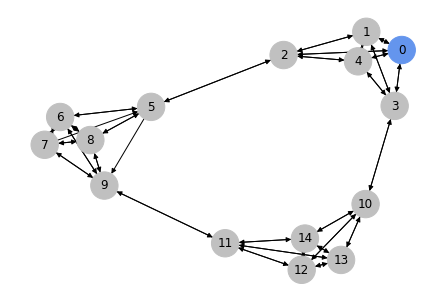

In [4]:
env = GraphEnv(
    graph_structure=GraphStructure.neighborhood, obs_type=GraphObsType.onehot
)
obs = env.reset(goal_pos=[0 for i in range(15)])
env.render()

pca = PCA(2)

### Plotting observation space projection

The observations corresponding to each node are one-hot encodings of the node index. As such, each node is orthogonal to all other nodes in representational space, and thre is no temporal community structure present in the underlying representation.

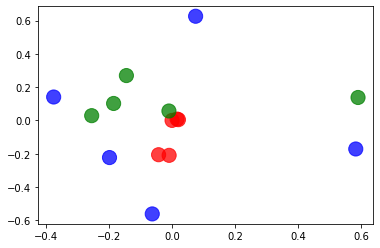

In [5]:
# Hyperparameters
num_steps = 200

all_obs = {}
obs = env.reset(goal_pos=[0 for i in range(15)])
idx = np.argmax(obs)
all_obs[idx] = obs
for i in range(num_steps):
    next_obs, _, _, _ = env.step(env.action_space.sample())
    obs = next_obs
    idx = np.argmax(obs)
    if idx not in all_obs.keys():
        all_obs[idx] = obs

colors_r = build_color_list(all_obs)
vals = np.stack(list(all_obs.values()))
result = pca.fit_transform(vals)
plot_projection(result, colors_r)

### Plotting predictive model projection

We can train a neural network with a single hidden layer to predict the next observation given the current observation drawn from a random walk of the graph. When plotting a 2D projection of the representation of the hidden layer, we see that nodes in the same local group share similarity in that space. 

In [6]:
class Predictor(nn.Module):
    def __init__(self, obs_size, h_size, lr):
        super(Predictor, self).__init__()
        self.encoder = nn.Linear(obs_size, h_size)
        self.decoder = nn.Linear(h_size, obs_size)
        self.optim = torch.optim.Adam(self.parameters(), lr)

    def forward(self, x):
        z = torch.tanh(self.encoder(x))
        pred_x = self.decoder(z)
        return pred_x, z

In [7]:
def collect_pairs(num_steps):
    xs = []
    ys = []
    ds = []

    obs = env.reset(goal_pos=[0 for i in range(15)])
    for j in range(num_steps):
        next_obs, _, _, _ = env.step(env.action_space.sample())
        xs.append(obs)
        ys.append(next_obs)
        ds.append(np.argmax(obs))
        obs = next_obs
    xs = torch.tensor(np.stack(xs))
    ys = torch.tensor(np.stack(ys))

    return xs, ys, ds

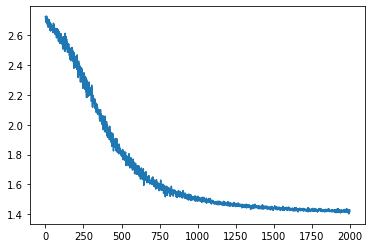

In [8]:
# Hyperparameters
hidden_units = 50
num_epochs = 2000
steps_per_epoch = 100
learning_rate = 5e-4

env = GraphEnv(
    graph_structure=GraphStructure.neighborhood, obs_type=GraphObsType.onehot
)
predictor = Predictor(env.state_size, hidden_units, learning_rate)

losses = []
for i in range(num_epochs):
    predictor.optim.zero_grad()
    xs, ys, ds = collect_pairs(steps_per_epoch)
    pred_ys, zs = predictor(xs)
    loss = torch.nn.functional.cross_entropy(pred_ys, ys)
    losses.append(loss.item())
    loss.backward()
    predictor.optim.step()
plt.plot(losses)

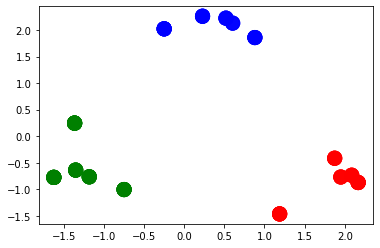

In [9]:
colors_z = build_color_list(ds)
zs = zs.detach()
result_z = pca.fit_transform(zs)
plot_projection(result_z, colors_z)

### Plotting successor representation projection

We can also train an agent utilizing a successor representation on random walks in the environments. When we project the learned successor matrix to a 2D space, we see that it also displays community structure.

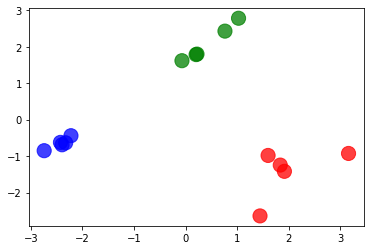

In [10]:
# Hyperparameters
num_train_episodes = 20
episode_length = 200

env = GraphEnv(graph_structure=GraphStructure.neighborhood, obs_type=GraphObsType.index)
agent = TDSR(env.state_size, env.action_space.n)

for i in range(num_train_episodes):
    agent, _ = run_episode(env, agent, goal_pos=[0 for i in range(15)], max_steps=episode_length)

M = np.mean(agent.M, axis=0)
result_sr = pca.fit_transform(M)
colors_sr = build_color_list(range(15))
plot_projection(result_sr, colors_sr)